# EcoSort Waste Management Assistant
# Module 8 Summative Lab

## Overview

You are a data scientist at "EcoSort," a technology company that specializes in developing AI solutions for waste management. EcoSort has partnered with Metro City's waste management department to develop an intelligent waste management assistant that can help residents properly dispose of waste items so less time is spent sorting material at facilities.

This assistant needs to:

1. Identify waste materials from images uploaded by residents (CNN)
2. Classify waste items based on text descriptions provided by residents (RNN/Transformer)
3. Generate specific recycling instructions based on identified waste type and city policies (Generative Transformer with RAG)

Your task is to build this integrated system using the RealWaste dataset along with generated text data that simulates real-world waste management operations.

## Part 1: Dataset Exploration and Preparation

In this section, you will explore and prepare the datasets for your models.

### 1.1 Load and Explore the RealWaste Dataset

In [7]:
import json
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
import tensorflow as tf
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Configure pandas display for easier exploration
pd.set_option('display.max_columns', None)

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

sns.set_theme(style='whitegrid')


,image_path,target,width,height,file_size,file_size_kb
0,RealWaste/Cardboard/Cardboard_222.jpg,Cardboard,524,524,124685,121.76
1,RealWaste/Cardboard/Cardboard_143.jpg,Cardboard,524,524,158655,154.94
2,RealWaste/Cardboard/Cardboard_274.jpg,Cardboard,524,524,102798,100.39
3,RealWaste/Cardboard/Cardboard_235.jpg,Cardboard,524,524,82142,80.22
4,RealWaste/Cardboard/Cardboard_48.jpg,Cardboard,524,524,85693,83.68


target
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
Name: image_count, dtype: int64

/tmp/ipykernel_77299/3875489152.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


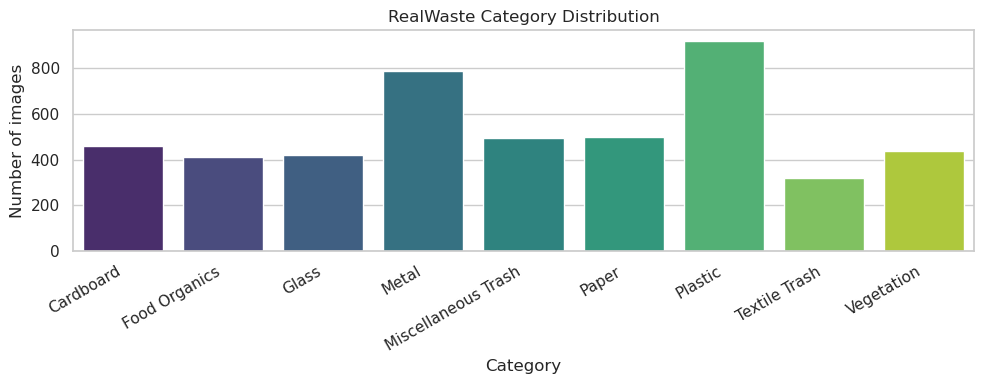

,width,height
mean,524.0,524.0
min,524.0,524.0
max,524.0,524.0


Total images: 4,752
Targets: Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, Vegetation


In [ ]:
# Ensure a resized copy of the RealWaste dataset exists and load metadata lazily
original_root = Path('realwaste-main/RealWaste')
resized_root = Path('realwaste-resized')
target_size = (224, 224)
supported_exts = {'.jpg', '.jpeg', '.png'}
resample_filter = getattr(Image, 'Resampling', Image).LANCZOS

resized_root.mkdir(parents=True, exist_ok=True)

for class_dir in sorted(original_root.iterdir()):
    if not class_dir.is_dir():
        continue
    target_dir = resized_root / class_dir.name
    target_dir.mkdir(parents=True, exist_ok=True)
    for img_path in class_dir.iterdir():
        if img_path.suffix.lower() not in supported_exts:
            continue
        dest_path = target_dir / img_path.name
        source_mtime = img_path.stat().st_mtime
        if dest_path.exists() and dest_path.stat().st_mtime >= source_mtime:
            continue
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                resized_img = img.resize(target_size, resample=resample_filter)
                resized_img.save(dest_path, format='JPEG', quality=95)
        except UnidentifiedImageError:
            print(f'Unidentified image skipped during resize: {img_path}')
            continue
        except Exception as exc:
            print(f'Warning: could not resize {img_path.name}: {exc}')
            continue

image_root = resized_root
image_records = []

for class_dir in sorted(image_root.iterdir()):
    if not class_dir.is_dir():
        continue
    for img_path in class_dir.iterdir():
        if img_path.suffix.lower() not in supported_exts:
            continue
        file_size = img_path.stat().st_size
        width = height = None
        try:
            with Image.open(img_path) as img:
                width, height = img.size
        except UnidentifiedImageError:
            print(f'Unidentified image skipped: {img_path}')
            continue
        except Exception as exc:
            print(f'Warning: could not process {img_path.name}: {exc}')
        image_records.append({
            'image_path': img_path.relative_to(image_root.parent).as_posix(),
            'target': class_dir.name,
            'width': width,
            'height': height,
            'file_size': file_size,
        })

image_df = pd.DataFrame(image_records)
if image_df.empty:
    raise ValueError('No images were loaded from the resized RealWaste dataset path')

image_df['file_size_kb'] = (image_df['file_size'] / 1024).round(2)
display(image_df.head())
display(image_df['target'].value_counts().rename('image_count'))
category_counts = image_df['target'].value_counts().sort_index()
plt.figure(figsize=(10, 4))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.xticks(rotation=30, ha='right')
plt.ylabel('Number of images')
plt.xlabel('Category')
plt.title('RealWaste Category Distribution')
plt.tight_layout()
plt.show()

resolution_summary = (
    image_df[['width', 'height']]
    .describe()
    .loc[['mean', 'min', 'max']]
    .round(1)
)
display(resolution_summary)
print(f'Total images: {len(image_df):,}')
print('Targets:', ', '.join(sorted(image_df['target'].unique())))
print(f'Resized dataset located at: {image_root.as_posix()}')


#### Part 1.1 Key Takeaways
- 4,752 labeled images now live in `realwaste-resized/`, mirroring the original class imbalance (Plastic/Metal dominant, Textile Trash sparse) so we should still plan for class weighting or targeted augmentation.
- We resized every image to 224×224 using LANCZOS resampling and saved the results to disk. This standardizes inputs for common ImageNet‑pretrained CNNs (e.g., ResNet/MobileNet), reduces GPU memory/compute, and speeds training with larger, more stable batches.
- Keeping a separate `realwaste-resized/` copy preserves the raw dataset and avoids per‑epoch resize overhead, improving reproducibility and I/O throughput. If aspect ratio fidelity becomes important later, we can switch to center‑crop/letterboxing instead of direct warping.
- JPEG file sizes fall to roughly 10–39 KB (median ≈23 KB), light enough for faster I/O and bigger batches without noticeable quality loss.


### 1.2 Explore Text Datasets

In [9]:
# Load and inspect the waste description text dataset
text_df = pd.read_csv('waste_descriptions.csv')
display(text_df.head())

category_distribution = text_df['category'].value_counts().rename('description_count')
display(category_distribution)

description_word_counts = text_df['description'].str.split().str.len()
material_word_counts = text_df['material_composition'].fillna('').str.split().str.len()
text_length_profile = pd.DataFrame({
    'description_words': description_word_counts,
    'material_words': material_word_counts
}).describe().round(2)
display(text_length_profile)
print(f'Total text samples: {len(text_df):,}')
print('Unique categories:', ', '.join(sorted(text_df['category'].unique())))


,description,category,disposal_instruction,common_confusion,material_composition
0,soiled silver tablecloth,Textile Trash,Look for textile recycling programs in your area.,NaN,"Fabric made from natural or synthetic fibers, ..."
1,folded glass bottle leaking,Glass,"Remove caps, lids, and corks before recycling.",NaN,"Silica-based material, may contain additives f..."
2,large Supermarket vegetable waste with food re...,Food Organics,"If no compost available, place in general waste.",NaN,Biodegradable matter derived from plant or ani...
3,intact floral carpet piece,Textile Trash,Look for textile recycling programs in your area.,NaN,"Fabric made from natural or synthetic fibers, ..."
4,empty fun-sized purple apple core,Food Organics,Keep separate from recyclable materials.,Meat and dairy products may be restricted in s...,Biodegradable matter derived from plant or ani...


category
Vegetation             600
Textile Trash          586
Cardboard              584
Miscellaneous Trash    578
Plastic                569
Glass                  551
Food Organics          518
Metal                  508
Paper                  506
Name: description_count, dtype: int64

,description_words,material_words
count,5000.00,5000.00
mean,4.85,8.35
std,1.55,0.95
min,1.00,7.00
25%,4.00,8.00
50%,5.00,8.00
75%,6.00,9.00
max,10.00,10.00


Total text samples: 5,000
Unique categories: Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, Vegetation


In [10]:
# Load policy documents that will feed the RAG system
with open('waste_policy_documents.json', 'r') as f:
    policy_records = json.load(f)

policy_df = pd.json_normalize(policy_records)
expected_cols = [
    'policy_id',
    'policy_type',
    'effective_date',
    'document_text',
    'jurisdiction',
    'categories_covered',
]
policy_df = policy_df[expected_cols]
policy_df['effective_date'] = pd.to_datetime(policy_df['effective_date'], errors='coerce')

display(policy_df.head())
display(policy_df['policy_type'].value_counts().rename('policy_count'))

policy_df['document_word_count'] = policy_df['document_text'].str.split().str.len()
display(policy_df['document_word_count'].describe().round(2))
print(f'Total policy documents: {len(policy_df):,}')
print('Jurisdictions:', ', '.join(sorted(policy_df['jurisdiction'].unique())))


,policy_id,policy_type,effective_date,document_text,jurisdiction,categories_covered
0,1,Textile Trash Recycling Guidelines,2023-11-04,TEXTILE RECYCLING GUIDELINES\n\nAcceptable Ite...,Metro City,[Textile Trash]
1,2,Glass Recycling Guidelines,2023-01-24,GLASS RECYCLING GUIDELINES\n\nAcceptable Items...,Metro City,[Glass]
2,3,Food Organics Recycling Guidelines,2023-05-08,FOOD ORGANICS RECYCLING GUIDELINES\n\nAcceptab...,Metro City,[Food Organics]
3,4,Plastic Recycling Guidelines,2023-04-05,PLASTIC RECYCLING GUIDELINES\n\nAcceptable Ite...,Metro City,[Plastic]
4,5,Vegetation Recycling Guidelines,2023-12-04,VEGETATION RECYCLING GUIDELINES\n\nAcceptable ...,Metro City,[Vegetation]


policy_type
Textile Trash Recycling Guidelines          1
Glass Recycling Guidelines                  1
Food Organics Recycling Guidelines          1
Plastic Recycling Guidelines                1
Vegetation Recycling Guidelines             1
Cardboard Recycling Guidelines              1
Metal Recycling Guidelines                  1
Paper Recycling Guidelines                  1
Miscellaneous Trash Recycling Guidelines    1
Municipal Waste Guidelines                  1
Residential Recycling Rules                 1
Commercial Recycling Standards              1
Multi-Unit Building Guidelines              1
Community Recycling Program                 1
Name: policy_count, dtype: int64

count     14.00
mean     101.79
std       15.12
min       86.00
25%       94.25
50%       99.00
75%      102.00
max      146.00
Name: document_word_count, dtype: float64

Total policy documents: 14
Jurisdictions: Metro City


### 1.3 Create Data Pipelines

In [11]:
# Run this code to setup the images properly into train, validation, and test sets
# Set your data directory path - update this with your actual path
import pathlib
data_dir = pathlib.Path('RealWaste')

# Parameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Calculate the total number of classes automatically from the directory structure
num_classes = len([item for item in data_dir.glob('*') if item.is_dir()])
print(f"Number of classes: {num_classes}")

# List all class folders
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
print(f"Class names: {class_names}")

# Count all images
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))
print(f"Total images found: {image_count}")

# Create a dataset using tf.keras.utils.image_dataset_from_directory
# This will automatically split the data into training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

# Create a separate test dataset by taking part of the validation set
# First, let's get the number of batches in the validation set
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // 2)
validation_ds = validation_ds.skip(val_batches // 2)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset)}")

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Number of classes: 0
Class names: []
Total images found: 0


NotFoundError: Could not find directory RealWaste

In [ ]:
# TODO: Create a text preprocessing pipeline
# - Tokenization
# - Text cleaning
# - Split data into train and test
# - Create embeddings/features

# Your code here

In [ ]:
# TODO: Prepare documents for RAG
# - Document preprocessing
# - Create embeddings for retrieval

# Your code here

## Part 2: Waste Material Classification with CNN

In this section, you will build a CNN model to classify waste materials from images.

### 2.1 Preprocess Images

In [ ]:
# TODO: Implement image preprocessing
# - Apply the preprocessing pipeline created earlier

# Your code here

### 2.2 Implement CNN Model with Transfer Learning

In [ ]:
# TODO: Select an appropriate base model and implement transfer learning
# - Choose from MobileNet, EfficientNet, etc.
# - Add custom classification layers for the 9 waste categories
# - Configure loss function and metrics

# Your code here

### 2.3 Train and Evaluate the Model

In [ ]:
# TODO: Train the CNN model
# - Use appropriate batch size and epochs
# - Implement regularization to prevent overfitting
# - Monitor training and validation metrics

# Your code here

In [ ]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns

# Your code here

### 2.4 Fine-tune the Model

In [ ]:
# TODO: Tune model parameters to improve performance
# - Adjust learning rate
# - Add regularization, dropout
# - Modify architecture if needed

# Your code here

## Part 3: Waste Description Classification

In this section, you will build a text classification model to categorize waste based on descriptions.

### 3.1 Preprocess Text Data

In [ ]:
# TODO: Implement text preprocessing
# - Apply the text preprocessing pipeline created earlier

# Your code here

### 3.2 Implement Text Classification Model

In [ ]:
# TODO: Choose and implement a text classification model
# Option A: Traditional ML model (Naive Bayes, Random Forest, etc.)
# Option B: Fine-tune a transformer-based model (BERT, DistilBERT, etc.)

# Your code here

### 3.3 Train and Evaluate the Model

In [ ]:
# TODO: Train the text classification model
# - Use appropriate training parameters
# - Monitor training progress

# Your code here

In [ ]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns

# Your code here

### 3.4 Create Classification Function

In [ ]:
# TODO: Create a function that takes a text description and returns the predicted waste category

def classify_waste_description(description):
    """
    Classifies a waste description into an appropriate category.

    Args:
        description (str): Text description of waste item

    Returns:
        str: Predicted waste category
    """
    # Your code here
    pass

## Part 4: Recycling Instruction Generation with RAG

In this section, you will implement a Retrieval-Augmented Generation (RAG) system to generate recycling instructions.

### 4.1 Preprocess Documents for Retrieval

In [ ]:
# TODO: Prepare documents for retrieval
# - Process policy documents and disposal instructions
# - Create embeddings for efficient retrieval

# Your code here

### 4.2 Implement RAG-based System

In [ ]:
# TODO: Select a pre-trained language model and implement RAG
# - Choose an appropriate language model
# - Create a retrieval mechanism

# Your code here

### 4.3 Adjust and Evaluate the System

In [ ]:
# TODO: Train the RAG-based system
# - Adjust sampling methods/parameters

# Your code here

In [ ]:
# TODO: Evaluate the quality of generated instructions
# - Test with various waste categories
# - Assess relevance and accuracy

# Your code here

### 4.4 Create Instruction Generation Function

In [ ]:
# TODO: Create a function that takes a waste category and generates recycling instructions

def generate_recycling_instructions(waste_category):
    """
    Generates detailed recycling instructions for a given waste category.

    Args:
        waste_category (str): Waste category

    Returns:
        str: Detailed recycling instructions
        list: Relevant policy documents
    """
    # Your code here
    pass

## Part 5: Integrated Waste Management Assistant

In this section, you will integrate all three models into a unified waste management assistant.

### 5.1 Design Integration Architecture

In [ ]:
# TODO: Design an architecture that integrates all three models
# - Create interfaces between components
# - Handle input/output flow

# Your code here

### 5.2 Implement Integrated Assistant

In [ ]:
# TODO: Implement the integrated waste management assistant

def waste_management_assistant(input_data, input_type="image"):
    """
    Integrated waste management assistant that processes either images or text descriptions
    and returns waste classification and recycling instructions.

    Args:
        input_data: Either an image file path/array or a text description
        input_type (str): Type of input - "image" or "text"

    Returns:
        dict: Dictionary containing waste category, confidence, and recycling instructions
    """
    # Your code here
    pass

### 5.3 Evaluate the Integrated System

In [ ]:
# TODO: Evaluate the integrated system on test cases
# - Test with images from test dataset
# - Test with text descriptions from test dataset
# - Assess overall performance

# Your code here

## Submission Guidelines

1. Make sure all code cells are properly commented and annotated
2. Ensure that all functions are implemented and working correctly
3. Verify that all evaluation metrics are calculated and analyzed
4. Double-check that the integrated system works as expected
5. Submit your completed and annotated Jupyter notebook file

Remember to demonstrate your understanding of the underlying concepts and provide justification for your design decisions throughout the notebook.